## Big Data Platforms - Winter 2023
## Final Project Education

### Twitter - Unique Message Analysis

#### Minh Vo

In [1]:
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
# import sh
from pyspark.sql.functions import *
from pyspark.sql.types import *
from itertools import compress

pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
warnings.filterwarnings(action='ignore')

In [2]:
pip install -U nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from google.cloud import storage

In [5]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Data Loading

In [6]:
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final/User-Groups/' | head -10

Found 341 items
-rwx------   3 root root          0 2023-03-10 00:12 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final/User-Groups/_SUCCESS
-rwx------   3 root root   63332184 2023-03-10 00:06 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final/User-Groups/part-00000-b009d9a6-e554-48e0-a750-de696a114c43-c000.snappy.parquet
-rwx------   3 root root   61951748 2023-03-10 00:06 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final/User-Groups/part-00001-b009d9a6-e554-48e0-a750-de696a114c43-c000.snappy.parquet
-rwx------   3 root root   61932482 2023-03-10 00:06 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final/User-Groups/part-00002-b009d9a6-e554-48e0-a750-de696a114c43-c000.snappy.parquet
-rwx------   3 root root   65444084 2023-03-10 00:06 gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final/User-Groups/part-00003-b009d9a6-e554-48e0-a750-de696a114c43-c000.snappy.parquet
-rwx------   3 root root   65033087 2023-03-10 00:06 gs://msca-bdp-students-bucket/shared_dat

In [7]:
path = 'gs://msca-bdp-students-bucket/shared_data/mdvo/BDP-Final/User-Groups/'

In [8]:
%%time

twtgroup_df = spark.read.parquet(path)
twtgroup_df.limit(5)

23/03/10 22:47:05 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 5.08 ms, sys: 4.4 ms, total: 9.47 ms
Wall time: 7.3 s


coordinates,favorite_count,filter_level,in_reply_to_screen_name,retweeted,retweet_count,retweeted_from,retweeted_status,text,country,country_code,full_name,place_type,bounding_box,timestamp_ms,id_str,name,screen_name,location,description,followers_count,statuses_count,created_at,verified,lang,is_original_twt,Twitterer_Group
null,0,low,null,RT,0,JesseKellyDC,"{null, Fri Sep 16...",RT @JesseKellyDC:...,null,null,null,null,null,1663357494824,1428048449195360262,Rick W. Thompson,Rick31883483,"Newburgh, IN",24 years U.S. Nav...,357,27662,Wed Aug 18 17:38:...,false,en,0,Others
null,0,low,null,,0,null,null,https://t.co/3U4h...,null,null,null,null,null,1663357497869,1510440453593829377,Manda Thompson,MandaThompson20,null,null,2,801,Sun Apr 03 02:14:...,false,en,1,Others
null,0,low,LGfL,,0,null,null,@LGfL includes so...,null,null,null,null,null,1663357498978,607019824,Dan Robinson ♥️🇺🇦,DanRobinsonBass,Walton on Thames,An advocate of ro...,378,3008,Wed Jun 13 08:28:...,false,en,1,Others
null,0,low,davidhogg111,,0,null,null,@davidhogg111 Whe...,null,null,null,null,null,1663357499317,1426649188222308355,Richard Maunder,rjm101163aux,"New Forest, UK",Forestry/wildlife...,182,27569,Sat Aug 14 20:58:...,false,en,1,Others
null,0,low,null,RT,0,GOPChairwoman,"{null, Fri Sep 16...",RT @GOPChairwoman...,null,null,null,null,null,1663357500719,1521254187262443521,Cathrine Colwell,CathrineColwell,null,null,56,1202,Mon May 02 22:24:...,false,en,0,Others


In [9]:
twtgroup_df.count()

24721729

In [10]:
twtgroup_df.groupby('Twitterer_Group').count().orderBy("count",ascending=False).toPandas()

,Twitterer_Group,count
0,Others,24343776
1,Social Media Influencers,226766
2,News Outlets,127342
3,Universities,9641
4,Schools,6209
5,Government Entities,5067
6,Non-Profit Organizations,2928


### How unique are the messages?

* Are they mostly unique? Or usually people are just copy-pasting the same text?
* You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
* Visualize message duplication for each group of Twitterers (government entities / non-profit organizations / news outlets / social media influencers / other)
<br> *Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis*

In [11]:
# work on Original tweets only
original_twts_group = twtgroup_df.filter(col('is_original_twt')==1)

In [12]:
original_twts_group.count()

8174910

In [13]:
original_twts_group.groupby('Twitterer_Group').count().orderBy("count",ascending=False).toPandas()

,Twitterer_Group,count
0,Others,7933421
1,Social Media Influencers,129547
2,News Outlets,97068
3,Universities,6315
4,Schools,3852
5,Government Entities,2764
6,Non-Profit Organizations,1943


In [14]:
nonprofit_twt = original_twts_group.filter(col('Twitterer_Group')=='Non-Profit Organizations')
gov_twt = original_twts_group.filter(col('Twitterer_Group')=='Government Entities')
univ_twt = original_twts_group.filter(col('Twitterer_Group')=='Universities')
school_twt = original_twts_group.filter(col('Twitterer_Group')=='Schools')
news_twt = original_twts_group.filter(col('Twitterer_Group')=='News Outlets')
influencer_twt = original_twts_group.filter(col('Twitterer_Group')=='Social Media Influencers')
other_twt = original_twts_group.filter(col('Twitterer_Group')=='Others')

In [15]:
group_sample = tweets_sample.select('id_str','text','Twitterer_Group')
group_sample.limit(5).toPandas()

NameError: name 'tweets_sample' is not defined

In [ ]:
# nonprofit_text = group_sample.filter(col('Twitterer_Group')=='Non-Profit Organizations')
# gov_text = group_sample.filter(col('Twitterer_Group')=='Government Entities')
# univ_text = group_sample.filter(col('Twitterer_Group')=='Universities')
# school_text = group_sample.filter(col('Twitterer_Group')=='Schools')
# news_text = group_sample.filter(col('Twitterer_Group')=='News Outlets')
# influencer_text = group_sample.filter(col('Twitterer_Group')=='Social Media Influencers')
# other_text = group_sample.filter(col('Twitterer_Group')=='Others')

#### Create a function to run the jaccard similarity

In [23]:

def generate_jaccard_sim(df, jaccard_distance):
    text = df.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

    # remove stopwords and tokenize text
    Stop_Words = stopwords.words("english")
    tokens = text\
            .map( lambda document: document.strip().lower())\
            .map( lambda document: re.split(r"\s+", document))\
            .map( lambda word: [x for x in word if x.isalnum()])\
            .map( lambda word: [x for x in word if len(x) > 3] )\
            .map( lambda word: [x for x in word if x not in Stop_Words])\
            .zipWithIndex()
    
    row = Row('text')
    df_text = text.map(row).zipWithIndex().toDF(['text','id'])
    
    #Drop records with no tokens
    df_tokens = spark.createDataFrame(tokens, ["list_of_words", "id"])
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

    # vectorize tokens using CountVectorizer
    vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
    df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

    # hash vectorized tokens using MinHashLSH
    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()
    
    df_hashed_text = df_text.join(df_hashed, "id", how='left').cache()
    
    # apply approximate Jaccard similarity on hashed tokens
    dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'))
    dups_text.cache()

    # calculate number of unique and total records
    dups = dups_text.select('id_A').distinct().count()
    records = df_hashed_text.count()
    uniques = records - dups

    return {'near_dups': dups, 'unique': uniques, 'records': records}

#### Pick a random sample to run the text similarity

In [53]:
# Run on original tweets only
# Choose a random sample of 1% from the original tweets data for analysis to avoid the crashing issue (due to the huge amount of data).
tweets_sample = original_twts_group.sample(fraction=0.01)
tweets_sample.count()

81809

In [54]:
tweets_sample.groupby('Twitterer_Group').count().orderBy("count",ascending=False).toPandas()

,Twitterer_Group,count
0,Others,79393
1,Social Media Influencers,1329
2,News Outlets,930
3,Universities,77
4,Schools,38
5,Government Entities,25
6,Non-Profit Organizations,17


In [56]:
text_sample = tweets_sample.select('id_str','text','Twitterer_Group')
text_sample_similarity = generate_jaccard_sim(text_sample, 0.3)
text_sample_similarity

{'near_dups': 7689, 'unique': 74120, 'records': 81809}

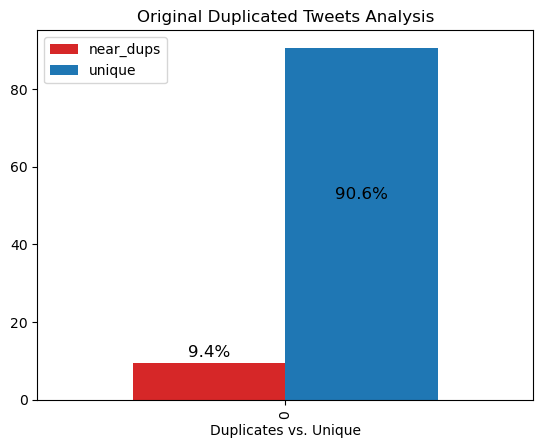

In [59]:
dups = text_sample_similarity['near_dups']/text_sample_similarity['records']*100
uniques = text_sample_similarity['unique']/text_sample_similarity['records']*100

text_sample_similarity_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = text_sample_similarity_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C3', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Original Duplicated Tweets Analysis', fontsize=12)
for p in ax.patches:
       ax.annotate(f"{format(p.get_height(), '.1f')}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0,21), 
                   textcoords = 'offset points',
                   fontsize = 12)

#### Run the text similarity on each user group

##### Non-profit organizations

In [ ]:
nonprofit_twt = original_twts_group.filter(col('Twitterer_Group')=='Non-Profit Organizations').select('id_str','text','Twitterer_Group')
nonprofit_similarity = generate_jaccard_sim(nonprofit_twt, 0.3)
nonprofit_similarity

{'near_dups': 303, 'unique': 1640, 'records': 1943}

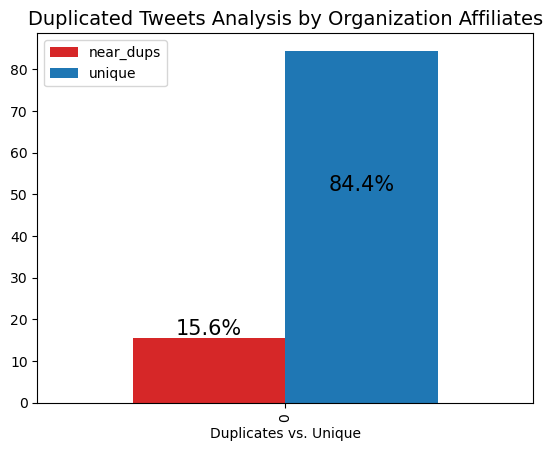

In [63]:
dups = nonprofit_similarity['near_dups']/nonprofit_similarity['records']*100
uniques = nonprofit_similarity['unique']/nonprofit_similarity['records']*100

nonprofit_similarity_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = nonprofit_similarity_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C3', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicated Tweets Analysis by Organization Affiliates', fontsize=14)
for p in ax.patches:
       ax.annotate(f"{format(p.get_height(), '.1f')}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0,30), 
                   textcoords = 'offset points',
                   fontsize = 15)

##### Government Entities

In [64]:
gov_twt = original_twts_group.filter(col('Twitterer_Group')=='Government Entities').select('id_str','text','Twitterer_Group')
gov_similarity = generate_jaccard_sim(gov_twt, 0.3)
gov_similarity

{'near_dups': 199, 'unique': 2565, 'records': 2764}

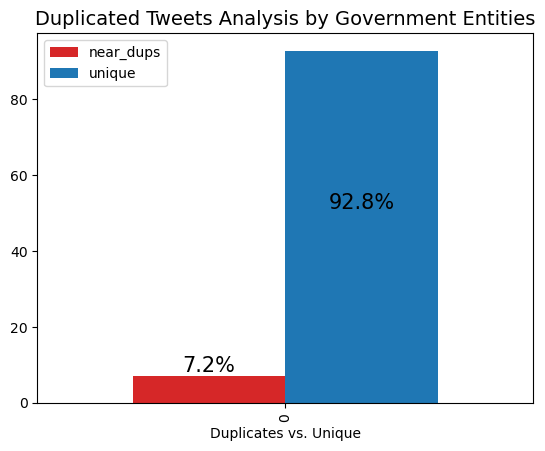

In [65]:
dups = gov_similarity['near_dups']/gov_similarity['records']*100
uniques = gov_similarity['unique']/gov_similarity['records']*100

gov_similarity_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = gov_similarity_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C3', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicated Tweets Analysis by Government Entities', fontsize=14)
for p in ax.patches:
       ax.annotate(f"{format(p.get_height(), '.1f')}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0,17), 
                   textcoords = 'offset points',
                   fontsize = 15)

##### Schools

In [32]:
school_twt = original_twts_group.filter(col('Twitterer_Group')=='Schools').select('id_str','text','Twitterer_Group')
school_similarity = generate_jaccard_sim(school_twt, 0.3)
school_similarity

{'near_dups': 299, 'unique': 3553, 'records': 3852}

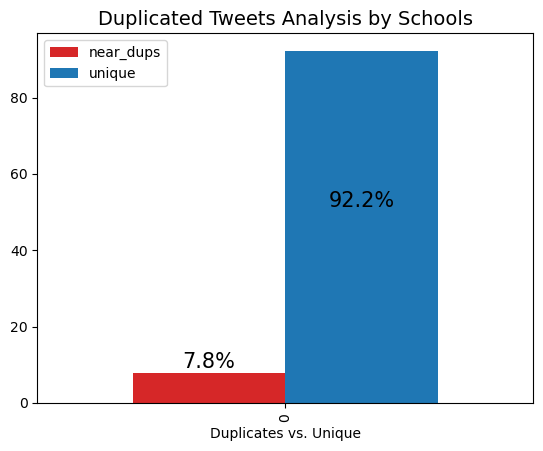

In [66]:
dups = school_similarity['near_dups']/school_similarity['records']*100
uniques = school_similarity['unique']/school_similarity['records']*100

school_similarity_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = school_similarity_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C3', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicated Tweets Analysis by Schools', fontsize=14)
for p in ax.patches:
       ax.annotate(f"{format(p.get_height(), '.1f')}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0,19), 
                   textcoords = 'offset points',
                   fontsize = 15)

##### Universities

In [36]:
univ_twt = original_twts_group.filter(col('Twitterer_Group')=='Universities').select('id_str','text','Twitterer_Group')
univ_similarity = generate_jaccard_sim(univ_twt, 0.3)
univ_similarity

{'near_dups': 423, 'unique': 5892, 'records': 6315}

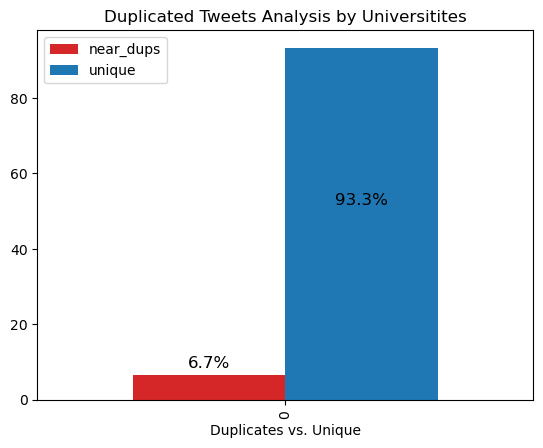

In [38]:
dups = univ_similarity['near_dups']/univ_similarity['records']*100
uniques = univ_similarity['unique']/univ_similarity['records']*100

univ_similarity_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = univ_similarity_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C3', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicated Tweets Analysis by Universitites', fontsize=12)
for p in ax.patches:
       ax.annotate(f"{format(p.get_height(), '.1f')}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0,17), 
                   textcoords = 'offset points',
                   fontsize = 12)

##### News Outlet

In [39]:
news_twt = original_twts_group.filter(col('Twitterer_Group')=='News Outlets').select('id_str','text','Twitterer_Group')
news_twt_sample = news_twt.sample(fraction=0.1)
news_similarity = generate_jaccard_sim(news_twt_sample, 0.3)
news_similarity

{'near_dups': 361, 'unique': 9227, 'records': 9588}

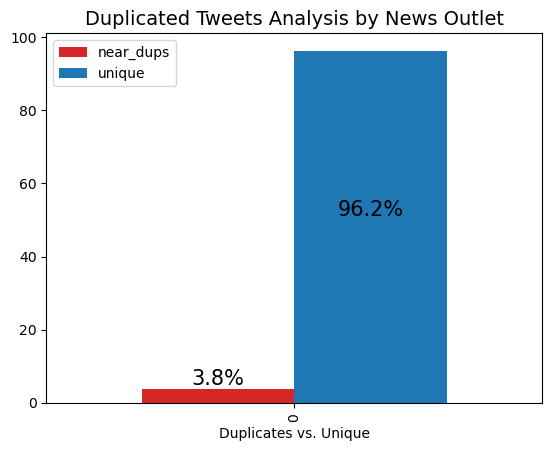

In [69]:
dups = news_similarity['near_dups']/news_similarity['records']*100
uniques = news_similarity['unique']/news_similarity['records']*100

news_similarity_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = news_similarity_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C3', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicated Tweets Analysis by News Outlet', fontsize=14)
for p in ax.patches:
       ax.annotate(f"{format(p.get_height(), '.1f')}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0,12), 
                   textcoords = 'offset points',
                   fontsize = 15)

##### Social Media Influencer

In [41]:
influencer_twt = original_twts_group.filter((col('Twitterer_Group')=='Social Media Influencers') & (col('verified')==True)).select('id_str','text','Twitterer_Group')
influencer_twt_sample = influencer_twt.sample(fraction=0.1)
influencer_similarity = generate_jaccard_sim(influencer_twt_sample, 0.3)
influencer_similarity

{'near_dups': 547, 'unique': 12410, 'records': 12957}

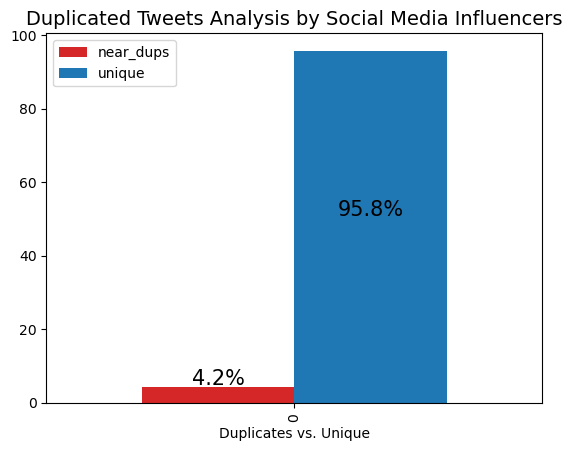

In [70]:
dups = influencer_similarity['near_dups']/influencer_similarity['records']*100
uniques = influencer_similarity['unique']/influencer_similarity['records']*100

influencer_similarity_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = influencer_similarity_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C3', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicated Tweets Analysis by Social Media Influencers', fontsize=14)
for p in ax.patches:
       ax.annotate(f"{format(p.get_height(), '.1f')}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0,12), 
                   textcoords = 'offset points',
                   fontsize = 15)

##### Others/Someone Else

In [43]:
other_twt = original_twts_group.filter(col('Twitterer_Group')=='Others').select('id_str','text','Twitterer_Group')
other_twt_sample = other_twt.sample(fraction=0.005)
other_similarity = generate_jaccard_sim(other_twt_sample, 0.3)
other_similarity

{'near_dups': 3190, 'unique': 36300, 'records': 39490}

In [ ]:
other_similarity = generate_jaccard_sim(other_twt_sample, 0.3)
other_similarity

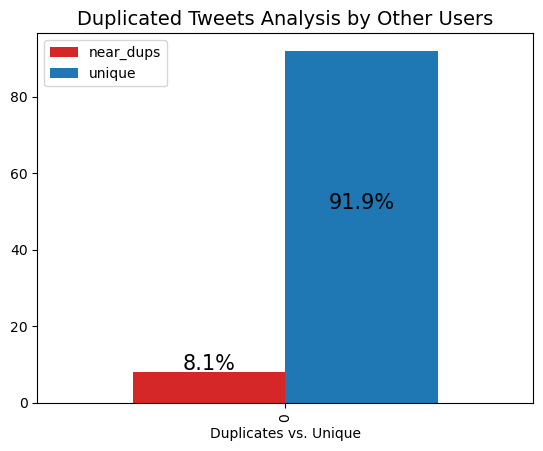

In [71]:
dups = other_similarity['near_dups']/other_similarity['records']*100
uniques = other_similarity['unique']/other_similarity['records']*100

other_similarity_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = other_similarity_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C3', 'C0'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Duplicated Tweets Analysis by Other Users', fontsize=14)
for p in ax.patches:
       ax.annotate(f"{format(p.get_height(), '.1f')}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0,17), 
                   textcoords = 'offset points',
                   fontsize = 15)